# Estimating surface area from reservoir depth
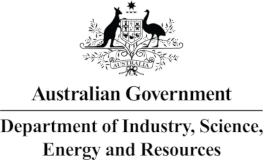
<img align="right" src="../Supplementary_data/dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with the `DEA Sandbox` environment only
* **Products used:** 
[ga_ls_wo_3](https://explorer.sandbox.dea.ga.gov.au/ga_ls_wo_3)
* **Special requirements:** CSV file containing water gauge depths
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook
* **Authors:** Katey Dugdale (Department of Industry, Science, Energy and Resources), Matthew Alger (Geoscience Australia)

## Background

Each year, Australia reports its greenhouse gas emissions to the United Nations under the Paris Agreement on Climate Change, including methane emissions from reservoirs and other constructed waterbodies. Methane is a greenhouse gas that is produced by bacteria that live in the soils of natural and constructed waterbodies. The amount of methane released from any waterbody can be estimated as a function of its water surface area. The surface area of large reservoirs may change a lot over the course of a year as they fill or empty due to rain and dam releases. To accurately calculate annual methane emissions from reservoirs, we need a monthly surface area time series to be able to capture this frequent changing of surface area.

A satellite image can show the top of a reservoir at a certain point in time, with water classifiers like Water Observations from Space (WOfS; Mueller et al. 2016) allowing us to determine the wet surface area of reservoirs (Krause et al. 2021). Unfortunately, the likelihood of getting a cloud-free pass of all of Australia’s reservoirs every month is low. A more reliable way to calculate the surface area would be to derive it from the depth gauge reading. Most of Australia’s reservoirs are gauged for daily readings and these data are made publicly available by the Bureau of Meteorology (BOM; http://www.bom.gov.au/waterdata/).

## Description

This notebook uses WOfS to collect images of a reservoir over the last 30 years and calculate its surface area at each meter of depth. It produces a table of 1m depth intervals and the corresponding surface area. The table can then be used to convert a depth time series into a surface area time series. 
Knowing the surface area of Australia’s reservoirs on a monthly timescale will greatly improve the accuracy of our national annual methane emission estimates from constructed waterbodies submitted to the United Nations each year.

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. Specify a reservoir to analyse in the "Parameters" section.

### Load packages
Import Python packages that are used for the analysis.

In [18]:
import csv
import os
import sys
import warnings

import datacube
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio.crs
import xarray as xr
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.utils import geometry, masking
from datacube.utils.geometry import CRS
from matplotlib import pyplot
from pandas import DataFrame
from tqdm.auto import tqdm

sys.path.append('../Tools/')
from dea_tools.bom import get_station_data, get_stations
from dea_tools.spatial import xr_rasterize
from dea_tools.waterbodies import get_time_series

### Parameters

Specify a waterbody using its DEA Waterbodies geohash:

In [2]:
waterbody = 'r6e094yk2'  # Lake Keepit

Specify the BOM Water Data Online station number for the storage gauge:

In [3]:
gauge_id = '419041'  # Namoi River at Keepit Dam - Storage Gauge

## Load the source time series

Load the DEA Waterbodies surface area time series and the storage gauge levels from the BOM.

In [4]:
surface_area_ts = get_time_series(waterbody)

We'll also convert the pixel counts into surface area in m$^2$.

In [39]:
surface_area_ts['m2_wet'] = surface_area_ts.px_wet * 25 ** 2  # Landsat pixels are 25m x 25m

To get the storage gauge data we have to first find the storage gauge:

In [5]:
observation_name = 'http://bom.gov.au/waterdata/services/parameters/Storage Level'
all_stations = get_stations(observation=observation_name)

In [6]:
matching_stations = [station for station in all_stations if station.url.endswith(gauge_id)]
assert matching_stations, f"No stations maxing gauge ID {gauge_id}"
matching_station = matching_stations[0]

In [9]:
gauge_level_ts = get_station_data(matching_station, observation=observation_name, param='Pat7_C_B_1_DailyMean')

## Align the time series

We need the dates of the gauge observations and the dates of the DEA Waterbodies satellite observations to line up so we can compare them.

First we have to normalise all dates to midnight to account for the fact observations were taken at different times:

In [24]:
surface_area_ts.index = surface_area_ts.index.normalize()
gauge_level_ts.index = gauge_level_ts.index.normalize()

We also need to drop the time zone information from DEA Waterbodies so that it works with the gauge level time series, which does not have any time zone information.

In [32]:
surface_area_ts = surface_area_ts.tz_convert(None)

Then we can find dates that were in both time series:

In [34]:
intersection_index = surface_area_ts.index.intersection(gauge_level_ts.index)

Finally, we can reindex both time series to have the same datetime index.

In [35]:
surface_area_ts = surface_area_ts.reindex(intersection_index)
gauge_level_ts = gauge_level_ts.reindex(intersection_index)

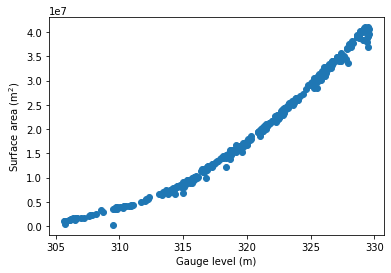

In [42]:
plt.scatter(gauge_level_ts, surface_area_ts.m2_wet)
plt.xlabel('Gauge level (m)')
plt.ylabel('Surface area (m$^2$)');

## Merge depth gauge data with surface area time series

We can link the gauge data and satellite data together on the time axis. Then we can refer to the surface areas by depth, instead of just by date.

In [49]:
gauge_level_ts.columns = ['gauge_level']

In [50]:
merged_data = pd.concat([gauge_level_ts, surface_area_ts], axis='columns')

In [54]:
assert not merged_data.gauge_level.isnull().any(), "Some gauge data are null"

## Organise the data by depth

Sort the time series by depth, and then separate it by depth intervals. If the reservoir has more than 25 m total variation, then we'll take intervals of 2 m; otherwise, we'll take intervals of 1m. The larger the interval, the more satellite passes we will have per depth interval, so we get more accurate measurements of surface area.

In [79]:
total_depth_variation = merged_data.gauge_level.max() - merged_data.gauge_level.min()
print('Total depth variation is', round(total_depth_variation, 2), 'm')

Total depth variation is 23.87 m


In [80]:
if total_depth_variation > 25:
    interval = 2
else:
    interval = 1
print('Using', interval, 'm intervals')

Using 1 m intervals


Generate the intervals:

In [87]:
intervals = np.arange(np.floor(merged_data.gauge_level.min()),
                      np.ceil(merged_data.gauge_level.max()) + 1,
                      interval)

Sort the data by depth rather than date, then assign each to the depth interval it belongs to.

In [88]:
merged_data = merged_data.sort_values('gauge_level')

In [91]:
merged_data['depth_interval'] = pd.cut(merged_data.gauge_level, intervals)

Then we can group by the depth interval and find the average surface area for each interval.

In [98]:
depth_to_area = merged_data.groupby('depth_interval').mean()

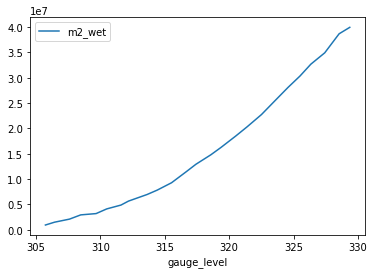

In [100]:
depth_to_area.plot('gauge_level', 'm2_wet')

## Clean up the data and interpolate

It doesn't make senes for the surface area to go down if the depth goes up, so now let's clean up any situations like that. If the surface area calculation is zero, or smaller than the one before it, we'll delete it. Missing values will be interpolaetd. If you are using 2 m intervals, above, this is where every other meter will be estimated too.

In [102]:
levels = []
for interval, level in depth_to_area.iterrows():
    if not levels:
        levels.append(level)
        continue
    
    if level.gauge_level <= levels[-1].gauge_level:
        raise RuntimeError('Gauge levels should only increase')
    
    if level.m2_wet > levels[-1].m2_wet:
        levels.append(level)
        continue

In [108]:
levels_df = pd.concat(levels, axis=1).T

Now we need to interpolate to integer depth values.

In [123]:
interp_depth_vals = np.arange(levels_df.index[0].left,
                              levels_df.index[-1].right,
                              1)

In [126]:
interp_area_vals = np.interp(interp_depth_vals, levels_df.gauge_level, levels_df.m2_wet)

## Export to CSV

Finally we can export to CSV. We want three columns: 1) the gauge ID, 2) the depth, 3) the surface area. We'll also floor the depth and area values, converting them into integers, to aid readability.

In [139]:
interp = pd.DataFrame({'id': [gauge_id] * len(interp_depth_vals),
                       'depth_m': interp_depth_vals.astype(int),
                       'area_m2': interp_area_vals.astype(int)})

In [140]:
interp.to_csv(f'depth_area_{waterbody}_{gauge_id}.csv', index=False)

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** May 2021

**Compatible datacube version:** 

In [17]:
print(datacube.__version__)

1.8.4.dev81+g80d466a2


## Tags
Browse all available tags on the DEA User Guide's [Tags Index](https://docs.dea.ga.gov.au/genindex.html)